In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import tensorflow as tf
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
class_names = ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '5', '6', '7', '8', '9']

In [3]:
labels_csv = pd.read_csv("labels.csv")
labels_csv.tail()

,Class,Label,Devanagari label,Phonetic,Type
41,41,patalosaw,स,sa,CONSONANT
42,42,ha,ह,ha,CONSONANT
43,43,ksha,क्ष,kṣa,CONSONANT
44,44,tra,त्र,tra,CONSONANT
45,45,gya,ज्ञ,jña,CONSONANT


In [4]:
model = tf.keras.models.load_model('nepali_ocr_model.h5')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 32, 32, 1)         0         
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 32, 32)        320       
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 16, 16, 64)        18496     
                                                      

1/1 [==============================] - 0s 209ms/step
This image most likely belongs to ब with a 99.18 percent confidence.


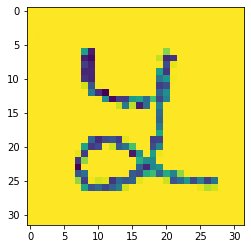

In [16]:
try_img = tf.keras.utils.load_img(
    "Assets/pics/5.jpeg", 
    target_size=(32, 32),
    color_mode='grayscale',
)
plt.imshow(try_img)

img_array = tf.keras.utils.img_to_array(try_img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

class_name = int(class_names[np.argmax(score)])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels_csv.loc[class_name, 'Devanagari label'], 100 * np.max(score))
)

In [25]:
def prediction(src):
    img = cv2.imread(src, 0)

    blur = cv2.GaussianBlur(img,(5,5),0)
    ret,img = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) #converts black to white and inverse

    plt.imshow(img)
    plt.show()

    img = cv2.resize(img, (32, 32))
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.erode(img, (3, 3), 1)
    
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    class_name = int(class_names[np.argmax(score)])
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(labels_csv.loc[class_name, 'Devanagari label'], 100 * np.max(score))
    )
    devanagari_label = labels_csv.loc[class_name, 'Devanagari label']
    success = 100 * np.max(score)
    
    return devanagari_label, success

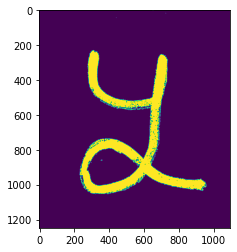

1/1 [==============================] - 0s 383ms/step
This image most likely belongs to ५ with a 99.86 percent confidence.


('५', 99.86181259155273)

In [26]:
prediction("Assets/pics/5.jpeg")

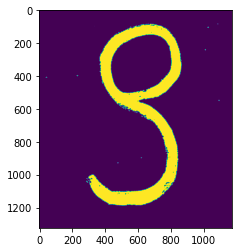

1/1 [==============================] - 0s 287ms/step
This image most likely belongs to ९ with a 99.97 percent confidence.


('९', 99.96575117111206)

In [27]:
prediction("Assets/pics/9.jpeg")

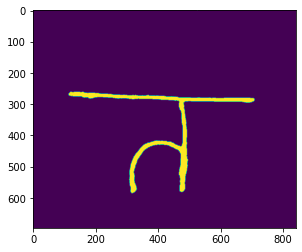

1/1 [==============================] - 0s 416ms/step
This image most likely belongs to ७ with a 59.01 percent confidence.


('७', 59.01322364807129)

In [29]:
prediction("Assets/yashuv/ta.jpg")

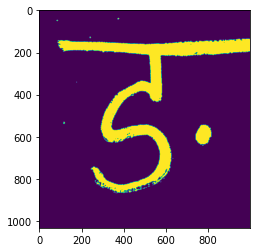

1/1 [==============================] - 0s 351ms/step
This image most likely belongs to ङ with a 99.59 percent confidence.


('ङ', 99.5888888835907)

In [31]:
prediction("Assets/pics/anga.jpeg")

## Cropping the Image (Pre-Processing)
A method to do preprocessing tasks like image cropping, background color finding.

In [32]:
def borders(here_img, textcolor, bthresh=0.092):
    shape = here_img.shape
    check= int(bthresh*shape[0])
    image = here_img[:]
    top, bottom = 0, shape[0] - 1


    #find the background color for empty column
    bg = np.repeat(textcolor, shape[1])
    count = 0
    for row in range(1, shape[0]):
        if  (np.equal(bg, image[row]).any()) == True:
            #print(count)
            count += 1
        else:
            count = 0
        if count >= check:
            top = row - check
            break
    

    bg = np.repeat(textcolor, shape[1])
    count = 0
    rows = np.arange(1, shape[0])
    #print(rows)
    for row in rows[::-1]:
        if  (np.equal(bg, image[row]).any()) == True:
            count += 1
        else:
            count = 0
        if count >= check:
            bottom = row + count
            break

    d1 = (top - 2) >= 0 
    d2 = (bottom + 2) < shape[0]
    d = d1 and d2
    if(d):
        b = 2
    else:
        b = 0
    
    return (top, bottom, b)


def preprocess(bgr_img):#gray image   
    blur = cv2.GaussianBlur(bgr_img,(5,5),0)
    ret,th_img = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) #converts black to white and inverse

    rows, cols = th_img.shape
    bg_test = np.array([th_img[i][i] for i in range(5)])
    if bg_test.all() == 0:
        text_color = 255
    else:
        text_color = 0
    
    tb = borders(th_img, text_color)
    lr = borders(th_img.T, text_color)
    dummy = int(np.average((tb[2], lr[2]))) + 2
    template = th_img[tb[0]+dummy:tb[1]-dummy, lr[0]+dummy:lr[1]-dummy]
    
    plt.imshow(template)
    plt.show()
    return (template, tb, lr)

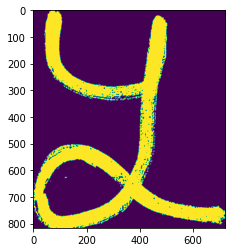

In [33]:
img = cv2.imread("Assets/pics/5.jpeg", 0)
prepimg, tb, lr = preprocess(img)

## Class: Devanagari Handwritten Character OCR

Here, many methods are defined for different purposes.
#### Methods: 
`show`, `main`, `preprocess`, `segmentation`, `localize`, `classifier`, `write_character`, `easy_flow`

In [5]:
from PIL import ImageDraw, Image, ImageFont

class DHC_OCR:
    def __init__(self, bthresh=0.092, min_seg=10, scheck=0.15):
        self.bthresh = bthresh
        self.check_color=5
        self.min_seg=min_seg
        self.scheck=scheck
        #self.thresh=thresh
        self.model = None
        self.fontPath="gargi.ttf"
        self.segment_prediction={}
        
    def show(self, img, figsize=(10, 10)):
        fig = plt.figure(figsize=figsize)
        plt.imshow(img, cmap="gray")
        plt.show()
          
    def borders(self, here_img, thresh):
        shape = here_img.shape
        check= int(self.bthresh*shape[0])
        image = here_img[:]
        top, bottom = 0, shape[0] - 1
    

        #find the background color for empty column
        bg = np.repeat(thresh, shape[1])
        count = 0
        for row in range(1, shape[0]):
            if  (np.equal(bg, image[row]).any()) == True:
                #print(count)
                count += 1
            else:
                count = 0
            if count >= check:
                top = row - check
                break


        bg = np.repeat(thresh, shape[1])
        count = 0
        rows = np.arange(1, shape[0])
        #print(rows)
        for row in rows[::-1]:
            if  (np.equal(bg, image[row]).any()) == True:
                count += 1
            else:
                count = 0
            if count >= check:
                bottom = row + count
                break

        d1 = (top - 2) >= 0 
        d2 = (bottom + 2) < shape[0]
        d = d1 and d2
        if(d):
            b = 2
        else:
            b = 0

        return (top, bottom, b)

    def preprocess(self, img):
        bgr_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(bgr_img,(5,5),0)
        ret,th_img = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) #converts black to white and inverse

        rows, cols = th_img.shape
        bg_test = np.array([th_img[i][i] for i in range(5)])
        if bg_test.all() == 0:
            text_color = 255
        else:
            text_color = 0
        self.bg_color=text_color
        tb = self.borders(th_img, text_color)
        lr = self.borders(th_img.T, text_color)
        dummy = int(np.average((tb[2], lr[2]))) + 2
        template = th_img[tb[0]+dummy:tb[1]-dummy, lr[0]+dummy:lr[1]-dummy]

        #plt.imshow(template)
        #plt.show()
        return (template, tb, lr)
    
    def segmentation(self, bordered):
        try:
            min_seg=self.min_seg
            scheck=self.scheck
            thresh=self.bg_color
            
            shape = bordered.shape
            check = int(scheck * shape[0])
            image = bordered[:]
            image = image[check:].T
            shape = image.shape
            #plt.imshow(image)
            #plt.show()

            #find the background color for empty column
            bg = np.repeat(255 - thresh, shape[1])
            bg_keys = []
            for row in range(1, shape[0]):
                if  (np.equal(bg, image[row]).all()):
                    bg_keys.append(row)            

            lenkeys = len(bg_keys)-1
            new_keys = [bg_keys[1], bg_keys[-1]]
            #print(lenkeys)
            for i in range(1, lenkeys):
                if (bg_keys[i+1] - bg_keys[i]) > check:
                    new_keys.append(bg_keys[i])
                    #print(i)

            new_keys = sorted(new_keys)
            #print(new_keys)
            segmented_templates = []
            first = 0
            bounding_boxes = []
            for key in new_keys[1:]:
                segment = bordered.T[first:key]
                if segment.shape[0]>=min_seg and segment.shape[1]>=min_seg:
                    segmented_templates.append(segment.T)
                    bounding_boxes.append((first, key))
                first = key

            last_segment = bordered.T[new_keys[-1]:]
            if last_segment.shape[0]>=min_seg and last_segment.shape[1]>=min_seg:
                segmented_templates.append(last_segment.T)
                bounding_boxes.append((new_keys[-1], new_keys[-1]+last_segment.shape[0]))

            #print(bounding_boxes)
            return(segmented_templates, bounding_boxes)
        except:
            return [[bordered], [(0, bordered.shape[1]-1)]]
    
    def localize(self, orig_img, tb, lr, segments):
        d=5
        rimg = orig_img.copy()
        boxes = []
        for simg, bb in zip(segments[0], segments[1]):
            bb = np.array(bb)
            bb += lr[0]
            # draw rows
            #rimg[tb[0]-d:tb[0], bb[0]-d:bb[1]+d] = 0
            #rimg[tb[1]:tb[1]+d, bb[0]-d:bb[1]+d] = 0

            # draw cols
            #rimg[tb[0]-d:tb[1]+d, bb[0]-d:bb[0]+d] = 0
            #rimg[tb[0]-d:tb[1]+d, bb[1]-d:bb[1]+d] = 0
            #print(tb, bb)
            boxes.append((tb[0]-d, tb[1]+d, bb[0], bb[1]))
            #show(rimg)
        rimg = self.img.copy()
        for box in boxes:
            t, b, l, r = box
            cv2.rectangle(rimg, (l, t), (r, b), (255-self.bg_color, 255-self.bg_color, 255-self.bg_color), d)
        #show(rimg)    
        self.boxes=boxes
        return rimg, boxes

    def prediction(self, img):
        # load model
        if self.model is None:
            loaded_model = tf.keras.models.load_model('nepali_ocr_model.h5')

        else:
            loaded_model=self.model

        
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        class_name = int(class_names[np.argmax(score)])
        print(
            "This image most likely belongs to {} with a {:.2f} percent confidence."
            .format(labels_csv.loc[class_name, 'Devanagari label'], 100 * np.max(score))
        )
        devanagari_label = labels_csv.loc[class_name, 'Devanagari label']
        success = 100 * np.max(score)

        return devanagari_label, success
    
    
    def write_character(self, img, pos, txt, fsize=5, fcolor=(0, 100, 100, 0)):
        img = Image.fromarray(img)
        draw = ImageDraw.Draw(img)
        font = ImageFont.truetype(self.fontPath, fsize)
        draw.text(xy=pos, text=txt, font=font, fill=fcolor)
        
        return np.array(img)
        
    def classifier(self, segments):
        pred_lbl = ""
        acc = []
        
        #print(len(segments))
        for i, segment in enumerate(segments[0]):
            if self.bg_color==0:
                segment=255-segment
                #self.show(segment)
            segment = cv2.resize(segment, (32, 32))
            segment = cv2.GaussianBlur(segment, (3, 3), 0)
            segment = cv2.erode(segment, (3, 3), 1)
            #show(segment)
            lbl, a = self.prediction(segment)
            self.segment_prediction[self.boxes[i]] = lbl
            
            pred_lbl+=lbl
            acc.append(a)
        return pred_lbl, np.array(acc).mean()

    def easy_flow(self, img, view="image"):
        prepimg, tb, lr = self.preprocess(img)
        segments=self.segmentation(prepimg)
        #print(segments[1])
        localized = self.localize(img, tb, lr, segments)
        op = self.classifier(segments)
        
        print(op)
        if view=="image":
            d = int(100*500/localized[0].shape[0])
            limg = self.write_character(localized[0], pos=(lr[1], tb[0]-d), txt=op[0], fsize=d)            
            self.show(img=limg)
        elif view=="frame":
            d = int(30*400/localized[0].shape[0])
            #print(d)
            limg = self.write_character(localized[0], pos=(lr[0], tb[0]-d), txt=op[0], fsize=d)
            self.show(img=limg)
            #print(limg.shape)
            cv2.imshow("Detection", limg)
        
    def camera(self, flag):
        choice = print("Click spacebar for photo and anything else for video.\n")
        orig = 1
        cap = cv2.VideoCapture(0)
        tr = 0.1
        br = 0.8
        lc = 0.1
        rc = 0.8
        f = 0

        while(flag):    
            ret, frame = cap.read()
            if ret:
                self.img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                #frame = cv2.flip(frame, 1)
                #key event
                s = cv2.waitKey(2) & 0xFF

                if(chr(s) == 'x'):
                    f = -1
                if(chr(s) == 'z'):
                    f = 1

                if(chr(s) == 'a'):
                    tr = tr + 0.1 * f
                if(chr(s) == 'd'):
                    br = br + 0.1 * f
                if (chr(s) == 's'):
                    lc = lc + 0.1 * f
                if (chr(s) == 'w'):
                    rc = rc + 0.1 * f


                s_x, s_y = np.shape(frame)[0] * tr, np.shape(frame)[1] * lc
                e_x, e_y = np.shape(frame)[1] * br, np.shape(frame)[0] * rc
                s_x, s_y = np.int32(s_x), np.int32(s_y)
                e_x, e_y = np.int32(e_x), np.int32(e_y)

                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                ogray = gray[:]
                gray = gray[s_y:e_y, s_x:e_x]
                self.img = self.img[s_y:e_y, s_x:e_x]
                #original = frame[s_y:e_y, s_x:e_x]

                if (s == 32): #space to capture image and do recognition
                    time1 = time.time()
                    self.show(frame, (10, 10))
                    self.easy_flow(self.img, "frame")
                    print("In %f" %(time.time()-time1), 'sec')
                if (s == 13): #enter to do realtime recognition
                    orig = 0
                    #cv2.destroyWindow('Project DCR')
                    print("Doing RT...")
                    self.easy_flow(self.img, "frame")


                else:
                    if(orig != 0):
                        show = frame[:]
                        text = "Press 'space' to take a photo and 'enter' to do realtime(slow)."
                        text1 = "Make sure the character is inside rectangle."
                        text2 = "a/s/d/w for change rectangle and z/x for inc/dec."
                        cv2.putText(show, text1, (15, 50), cv2.FONT_HERSHEY_COMPLEX, 0.75, (0, 100, 200))
                        cv2.putText(show, text2, (0, np.shape(frame)[0] - 10), cv2.FONT_HERSHEY_COMPLEX, 0.65, (50, 20, 255))
                        cv2.rectangle(show, (s_x, s_y), (e_x, e_y), (0, 255, 0), 2)
                        cv2.putText(show, text, (15, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (15, 0, 255), lineType=cv2.LINE_AA) 
                        cv2.imshow('Project DCR', show)

            else:
                print('Trying.....\n')
                continue


            if s == 27:
                break
        cap.release()
        cv2.destroyAllWindows()
        
        
#     Just Img mode function
    # def main(self, img=None):
    #     img = cv2.imread(img, 1)
    #     self.img=img
    #     #self.show(img)
    #     time1 = time.time()

    #     self.easy_flow(img)
    #     print("In %f" %(time.time()-time1), 'sec')
    
    def main(self, img=None):
        if img is None:
            # go to Camera mode
            self.use_camera(True)
        else:
            try:
                img = cv2.imread(img, 1)
                self.img=img
                #self.show(img)
                time1 = time.time()
                
                self.easy_flow(img)
                
                print("In %f" %(time.time()-time1), 'sec')
            except:
                print("Image not found now turning to video mode.\n")
                try:
                    self.camera(True)
                except:
                    print('Something is wrong. Try with more stable, less noise and clear picture.\n')
                #cap.release()
                cv2.destroyAllWindows()


1/1 [==============================] - 0s 179ms/step
This image most likely belongs to ५ with a 99.99 percent confidence.
1/1 [==============================] - 0s 137ms/step
This image most likely belongs to ८ with a 100.00 percent confidence.
('५८', 99.99397397041321)


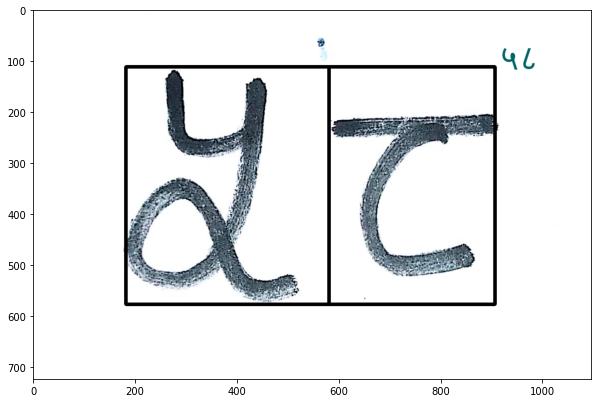

In 3.210001 sec


{(111, 577, 182, 581): '५', (111, 577, 581, 907): '८'}

In [36]:
docr = DHC_OCR()
docr.main(img="Assets/yashuv/58.jpeg")
docr.segment_prediction

1/1 [==============================] - 0s 221ms/step
This image most likely belongs to र with a 37.50 percent confidence.
1/1 [==============================] - 0s 214ms/step
This image most likely belongs to घ with a 99.97 percent confidence.
1/1 [==============================] - 0s 175ms/step
This image most likely belongs to र with a 100.00 percent confidence.
('रघर', 79.154039422671)


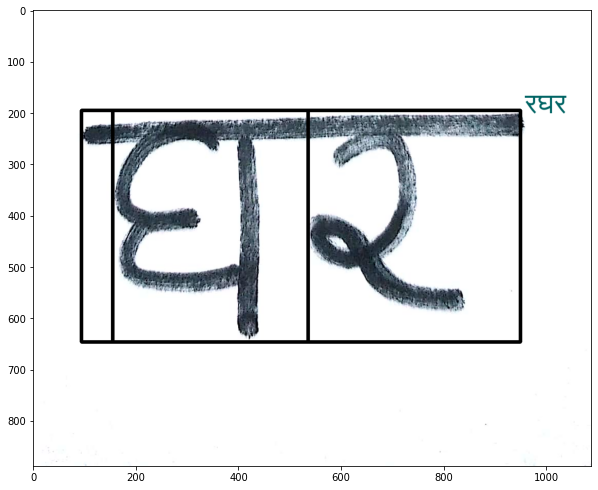

In 4.659996 sec


{(195, 646, 94, 155): 'र',
 (195, 646, 155, 536): 'घ',
 (195, 646, 536, 950): 'र'}

In [37]:
docr = DHC_OCR()
docr.main(img="Assets/yashuv/ghar.jpeg")
docr.segment_prediction

1/1 [==============================] - 0s 175ms/step
This image most likely belongs to क with a 100.00 percent confidence.
1/1 [==============================] - 0s 215ms/step
This image most likely belongs to ल with a 99.91 percent confidence.
('कल', 99.95225071907043)


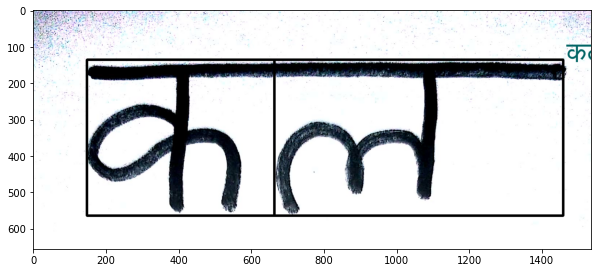

In 3.619998 sec


{(136, 564, 148, 664): 'क', (136, 564, 664, 1459): 'ल'}

In [38]:
docr = DHC_OCR()
docr.main(img="Assets/yashuv/kal.jpeg")
docr.segment_prediction

Image not found now turning to video mode.

Click spacebar for photo and anything else for video.



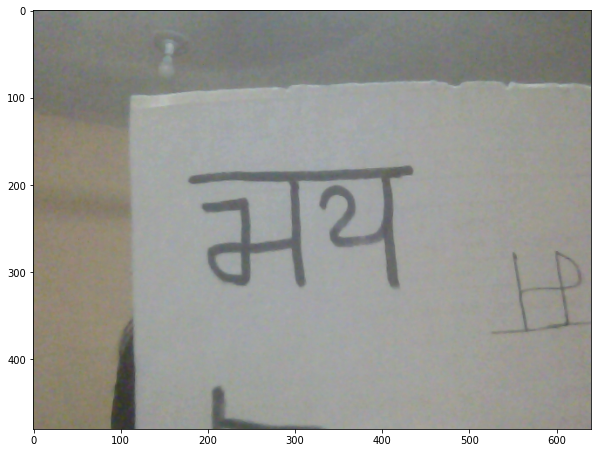

1/1 [==============================] - 1s 976ms/step
This image most likely belongs to ब with a 80.83 percent confidence.
('ब', 80.82702159881592)


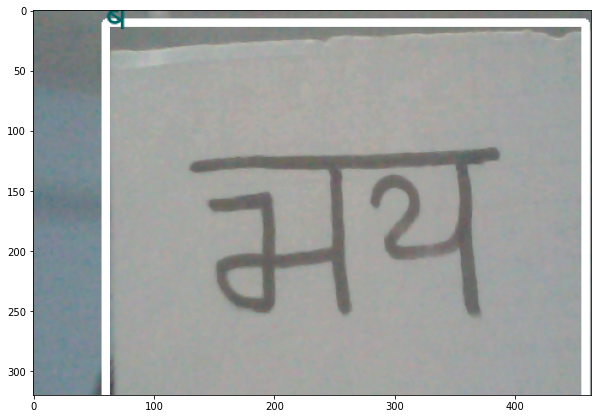

In 4.063528 sec


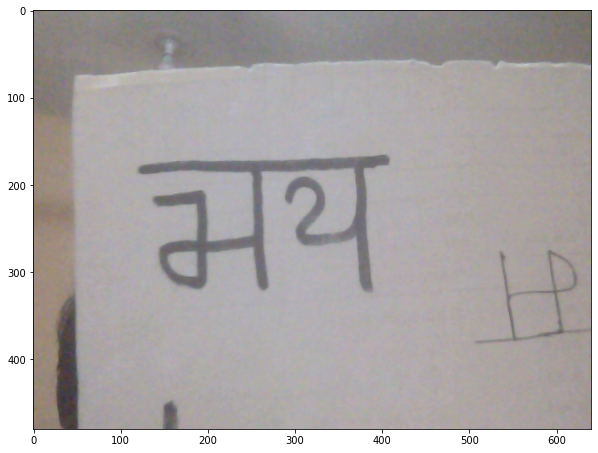

1/1 [==============================] - 0s 251ms/step
This image most likely belongs to ब with a 95.92 percent confidence.
('ब', 95.91804146766663)


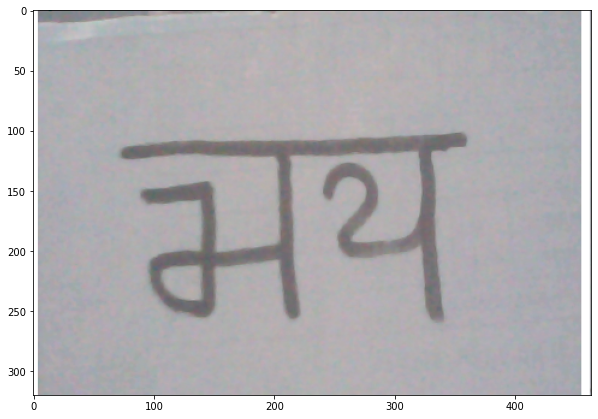

In 3.021997 sec


{(10, 325, 60, 459): 'ब', (-5, 325, 0, 459): 'ब'}

In [6]:
docr = DHC_OCR()
docr.main(img="Asim")
docr.segment_prediction

Image not found now turning to video mode.

Click spacebar for photo and anything else for video.



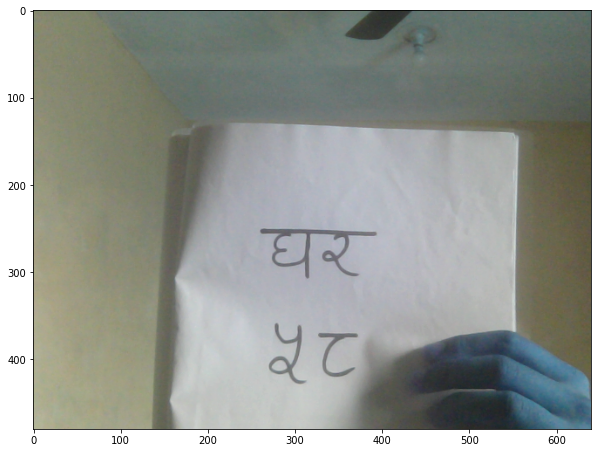

1/1 [==============================] - 0s 272ms/step
This image most likely belongs to ड with a 76.36 percent confidence.
1/1 [==============================] - 0s 356ms/step
This image most likely belongs to ब with a 97.96 percent confidence.
('डब', 87.1589183807373)


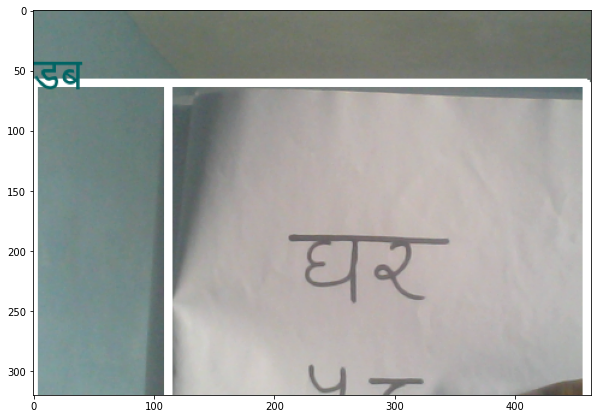

In 4.048998 sec


{(60, 325, 0, 112): 'ड', (60, 325, 112, 460): 'ब'}

In [8]:
docr = DHC_OCR()
docr.main(img="Asim")
docr.segment_prediction